# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import random
import itertools
from tqdm.notebook import tqdm
import pickle
from lifetimes.utils import summary_data_from_transaction_data
from functools import reduce
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

tqdm.pandas()

In [2]:
DATA = pd.read_pickle('../../data/sales7_8_pd115.pkl')

In [3]:
BERT = np.load('../../data/item_emb78.npy', allow_pickle=True)[None][0]

In [4]:
def generate_pca_df(components, df):
  pca = PCA(n_components=components)
  pca_result = pca.fit_transform(df)
  plt.figure(figsize=(30, 5))
  plt.plot(pca.explained_variance_ratio_.cumsum())
  print(pca.explained_variance_ratio_.cumsum())
  return pd.DataFrame(pca_result, index=df.index)

---
## Item Embedding

In [5]:
# Append item embeddings according to items list's order & convert to np array
item_names = DATA['處理後名稱'].unique().tolist()
ITEM_EMB_BY_IDX = []
for iname in item_names: ITEM_EMB_BY_IDX.append(BERT[iname])

# get embedding by uniq_item_idx
ITEM_EMB_BY_IDX = np.array(ITEM_EMB_BY_IDX)

# DATA[修改後名稱] -> uniq_item_idx
uniq_item_idx_dict = {name:i for i, name in enumerate(item_names)}

將 `DATA['處理後名稱']` map 到 uniq_item_idx，記錄於欄位： `DATA['uniq_item_idx']`

In [6]:
DATA['uniq_item_idx'] = DATA['處理後名稱'].progress_apply(lambda x: uniq_item_idx_dict[x])

  0%|          | 0/5487791 [00:00<?, ?it/s]

---
## Streamer Context

In [7]:
# 學姊寫的 RFML under streamers

def generate_static_user_context(txn_data, end_date):
    txn_data = txn_data[txn_data.asid != 'blank']
    # 計算顧客RFM
    rfm = summary_data_from_transaction_data(txn_data, 'asid', '下單日期', '總金額',observation_period_end=end_date, include_first_transaction=True) 
    # 類別變數
    tmp = txn_data.groupby(['asid']).agg(
        payment_method = ("付款方式", lambda x: pd.Series.mode(x)[0]),
        shipping_method = ("運送方式", lambda x: pd.Series.mode(x)[0]) # 眾數會回傳多個(如果頻率一樣時, 取第一個)
    )
    static_df = rfm.reset_index().merge(tmp.reset_index(), how='left', on='asid') # rfm人可能比tmp還少(有的人算不出rfml), 所以用left_join
    address = pd.read_csv('../../data/prev/user_address.csv', index_col=0, dtype={'asid': str, 'city': str, 'area': str})
    address = address[address.asid != 'blank']
    static_df = static_df.merge(address, how='left', on='asid')
    # static_df = pd.get_dummies(static_df, columns=['payment_method','shipping_method','city','area'])
    static_df = pd.get_dummies(static_df, columns=['payment_method','shipping_method','city']) # area太多了先拿掉
    return rfm, static_df

def generate_streamer_features(streamer_static_fname, txn_data, cmt_data, rfm_data, end_date):
    # 讀取直播主靜態特徵
    streamer_static = pd.read_csv(streamer_static_fname,
                    converters={
                        'user_id':str,
                        })
    # 抓出頻道的買家清單
    usr_asid = txn_data.groupby(['user_id','asid'])['付款單號'].nunique().reset_index(level=['user_id','asid'])
    # 合併
    df = usr_asid.merge(rfm_data, how='left', on='asid')
    # 計算streamer平均顧客RFML
    rfm_df = df.groupby('user_id').agg(
        avg_recency = ('recency', 'mean'),
        avg_frequency = ('frequency', 'mean'),
        avg_monatory = ('monetary_value', 'mean'),
        avg_length = ('T', 'mean')
    )
    # 計算streamer的活躍/沈睡顧客數
    no_exist = df.groupby(['user_id']).agg({
        'frequency': lambda x: sum(x<=np.mean(x)),
    }).reset_index().rename(columns={'frequency': 'no_exist'})

    no_sleep = df.groupby(['user_id']).agg({
        'frequency': lambda x: sum(x>3*np.mean(x)),
    }).reset_index().rename(columns={'frequency': 'no_sleep'})
    # 計算streamer商品數量(隨時間而變,找出首販日)
    tmp = txn_data.groupby(['商品id','user_id']).agg({
        '下單日期': 'first'
    }).rename(columns={'下單日期':'首販日'}).reset_index() #.sort_values(by=['user_id','首販日'])
    no_prod = tmp[tmp.首販日<=end_date].iloc[:,:2].user_id.value_counts().reset_index().rename(columns={'index': 'user_id', 'user_id': 'no_prod'})
    # 計算streamer訂單數量(隨時間而變)
    no_orders = txn_data[txn_data.下單日期<=end_date].groupby('user_id')['付款單號'].count().reset_index().rename(columns={'付款單號': 'no_orders'})
    # 計算streamer每月平均直播次數(不隨時間而變)
    # cmt['month'] = cmt.created_time.dt.month
    # no_video = cmt.groupby(['user_id','month'])['video_id'].nunique().reset_index().rename(columns={'video_id': 'no_video'}).groupby(['user_id']).mean('no_video')
    # 因為3月和5月的留言資料非常少，取平均會被拉低，這邊直接加總/或取單一完整月份(即4月)資料替代
    no_video = cmt_data.groupby('user_id')['video_id'].nunique().reset_index().rename(columns={'video_id': 'no_video'})
    # 計算streamer每月平均直播參與人數(不隨時間而變)
    no_engage_cust = cmt_data.groupby(['user_id','video_id']).from_id.nunique().reset_index(level=['user_id','video_id'])
    no_engage_cust = no_engage_cust.groupby('user_id').from_id.sum().reset_index().rename(columns={'from_id': 'no_engage_cust'})
    # 合併
    dfs = [rfm_df, no_exist, no_sleep, streamer_static, no_prod, no_orders, no_video, no_engage_cust]
    streamer = reduce(lambda left,right: pd.merge(left, right, how='left', on='user_id'), dfs).fillna(0)
    streamer = streamer.set_index(streamer.columns[0])
    return streamer

In [94]:
def standardize(data):
    scale_array = StandardScaler().fit_transform(data)
    scale_df = pd.DataFrame(scale_array, columns=data.columns, index=data.index).reset_index()
    return scale_df

In [95]:
txn = pd.read_pickle('../../data/prev/txn.pkl')
cmt = pd.read_pickle('../../data/prev/cmt.pkl')

end_date = '2021-11-01'
sub_txn = txn[txn.user_id.isin(['10891','12235','27343','6835','6897','4123','4793'])]
sub_txn.user_id.value_counts()
streamer_static_fname='../../data/prev/streamer_static_features_9.csv'

rfm, static_df = generate_static_user_context(sub_txn, end_date)
streamer2 = generate_streamer_features(streamer_static_fname, sub_txn, cmt, rfm, end_date) # 製作streamer features
scale_streamer = standardize(streamer2)     # 標準化

In [105]:
scale_streamer.columns

Index(['user_id', 'avg_recency', 'avg_frequency', 'avg_monatory', 'avg_length',
       'no_exist', 'no_sleep', 'fb_likes', 'fb_followers', 'app_likes',
       'fix_time_for_live', 'gender', 'multi-streamers', '購物與零售', '服飾店', '精品店',
       '商品與服務', '鞋店', '居家裝飾', '美食與飲料', '生活百貨', '肉品批發商', '寵物', 'no_prod',
       'no_orders', 'no_video', 'no_engage_cust'],
      dtype='object')

In [112]:
streamer2 = streamer2.rename(columns={'購物與零售': 'retail', '服飾店': 'cloth', '精品店': 'luxuary',
       '商品與服務': 'services', '鞋店': 'shoe', '居家裝飾': 'home', '美食與飲料': 'food', '生活百貨': 'living', '肉品批發商': 'meat', '寵物': 'pet'})
scale_streamer = scale_streamer.rename(columns={'購物與零售': 'retail', '服飾店': 'cloth', '精品店': 'luxuary',
       '商品與服務': 'services', '鞋店': 'shoe', '居家裝飾': 'home', '美食與飲料': 'food', '生活百貨': 'living', '肉品批發商': 'meat', '寵物': 'pet'})

In [113]:
streamer2.to_pickle('../../data/streamer.pkl')
scale_streamer.to_pickle('../../data/scale_streamer.pkl')

---
## User Context

### Basic Settings for stream col

In [41]:
DATA = DATA.drop(columns=['樣式', '寄送地址', '商品名稱'])

In [42]:
address = pd.read_csv('../../data/prev/user_address.csv', index_col=0, dtype={'asid': str, 'city': str, 'area': str})

FileNotFoundError: [Errno 2] No such file or directory: '../../data/prev/user_address.csv'

In [9]:
address.rename(columns={'asid':'consumer_id'}, inplace=True)
address.head()

,consumer_id,city,area
0,100000231461089,自取點,益民總店
1,1000057940522534,高雄市,梓官區
2,1000060790463557,高雄市,鳳山區
3,1000082590775367,新北市,鶯歌區
4,1000125800421136,屏東縣,枋寮鄉


In [10]:
DATA = DATA.merge(address, on='consumer_id')

In [7]:
DATA = DATA.sort_values(by=['訂單編號'])

In [8]:
replacements_series = DATA['streamer_id'].astype(str) + '-' + DATA['date']
DATA['場次'] = DATA['場次'].fillna(value=DATA['date'].astype(str))
DATA['場次'] = DATA['streamer_id'].astype(str) + '-' + DATA['場次'].astype(str)
DATA.rename(columns={'場次':'stream'}, inplace=True)

In [9]:
DATA['stream'] = DATA['stream'].astype(str)

In [10]:
DATA['stream'].nunique()

9341

In [11]:
sorted_streams = DATA.sort_values(by=['訂單編號', '下單日期'])['stream'].reset_index(drop=True).unique()
stream_dict = { x: i for i, x in enumerate(sorted_streams) }

DATA['stream'] = DATA['stream'].map(stream_dict)

### User Stream Static Context

In [15]:
'''
One Hot Encoding
* 處理 shipment, payment
* 要先做 label encoding 才能做 one hot encoding
'''
le = LabelEncoder()

DATA['shipment'] = le.fit_transform(DATA['運送方式'])
DATA['payment'] = le.fit_transform(DATA['付款方式'])
DATA = pd.get_dummies(DATA,
                      prefix=['shipment', 'payment'],
                      columns=['shipment', 'payment'])

In [16]:
'''
USER Features 
Generate user_static_df
'''
data_groupby_user_stream = DATA.groupby(['consumer_id', 'stream'])


# Get group by sum
user_static_df = data_groupby_user_stream.sum()
user_static_df = user_static_df[['shipment_0', 'shipment_1', 'shipment_2', 'shipment_3', 
                                 'shipment_4', 'shipment_5', 'shipment_6', 'payment_0', 
                                 'payment_1', 'payment_2', 'payment_3', 'payment_4', 'payment_5',
                                 'payment_6', 'payment_7', 'payment_8']]


# Get group by count & mean
u_s_count = data_groupby_user_stream.count()
u_s_avg = data_groupby_user_stream.mean()

# Assign seleted values to user_static_df
user_static_df[['channel_name', 'streamer_id', 'item_id', '訂單編號', '專屬折扣']] = u_s_count[['channel_name', 'streamer_id', 'item_id', '訂單編號', '專屬折扣']]
user_static_df[['運費', '總金額', '數量', '單價']] = u_s_avg[['運費', '總金額', '數量', '單價']]

# Rename columns
user_static_df.rename(columns={'channel_name': 'channel_cnt',
                                '訂單編號': 'order_cnt',
                                'item_id': 'item_var_cnt',
                                '運費': 'shipment_fee',
                                '專屬折扣': 'discount',
                                '總金額': 'total_price',
                                '單價': 'avg_item_price',
                                '數量': 'avg_item_cnt'
                               },
                           inplace=True)

shipment_0  shipment_1  shipment_2  \
consumer_id                       stream                                       
100000231461089                   8526             0           0           0   
1000057940522534                  3731             0           0           0   
                                  3742             0           0           0   
                                  4215             0           0           0   
                                  4267             0           0           0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461              0           0           0   
                                  842              0           0           0   
                                  1006             0           0           0   
Uffbbcd4c509268b8b16147e5e128722e 5623             0           0           0   
                                  5709             0           0           0   

                                          shipment_3  shipment_4  shipment_5  \
consumer_id                       stream                                       
100000231461089                   8526             1           0           0   
1000057940522534                  3731             5           0           0   
                                  3742             3           0           0   
                                  4215             2           0           0   
                                  4267             5           0           0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461              2           0           0   
                                  842              3           0           0   
                                  1006             4           0           0   
Uffbbcd4c509268b8b16147e5e128722e 5623             1           0           0   
                                  5709             2           0           0   

                                          shipment_6  payment_0  payment_1  \
consumer_id                       stream                                     
100000231461089                   8526             0          0          0   
1000057940522534                  3731             0          0          0   
                                  3742             0          0          0   
                                  4215             0          0          0   
                                  4267             0          0          0   
...                                              ...        ...        ...   
Uffb50137571903b41efcbb49829729a7 461              0          0          0   
                                  842              0          0          0   
                                  1006             0          0          0   
Uffbbcd4c509268b8b16147e5e128722e 5623             0          0          0   
                                  5709             0          0          0   

                                          payment_2  payment_3  payment_4  \
consumer_id                       stream                                    
100000231461089                   8526            0          0          0   
1000057940522534                  3731            0          0          0   
                                  3742            0          0          0   
                                  4215            0          0          0   
                                  4267            0          0          0   
...                                             ...        ...        ...   
Uffb50137571903b41efcbb49829729a7 461             0          0          0   
                                  842             0          0          0   
                                  1006            0          0          0   
Uffbbcd4c509268b8b16147e5e128722e 5623            0          0          0   
                     

### Weighted Average Item Embedding

In [19]:
'''
Calculate user cumulated stream embedding
* user_stream_order_dict: { User: [stream list in order] }
* buy list: [consumer_id, streams]
* 需求：可以選擇要「給予權重」或「直接平均」
'''
user_stream_order = DATA[['consumer_id', 'stream']].groupby(['consumer_id'])['stream'].apply(set)
USER_LIST = DATA['consumer_id'].unique().tolist()
# test consumer_id: ['1000057940522534']
# test streams: {3627, 3638, 4091, 4141, 4707, 4841, 4942, 5508}

In [20]:
user_stream_order['1000057940522534']

{3731, 3742, 4215, 4267, 4852, 4993, 5107, 5712}

In [21]:
user_stream_buy_list = DATA.groupby(['consumer_id', 'stream'])['uniq_item_idx'].apply(list)

In [22]:
# WEIGHTED
FINAL_EMB = {}
for consumer_id in tqdm(USER_LIST):
  # find all the stream user attended and sort them in time order
  streamlist = list(user_stream_order[consumer_id])
  streamlist.sort()
  # find items bought in each stream
  buylist = [user_stream_buy_list[consumer_id, stream] for stream in streamlist]
  
  # convert buylist to bert embeddings
  single_stream_emb = []
  for items in buylist:
    # all_buy_item_index = [BERT_INDEX[item] for item in items]
    single_stream_emb.append(ITEM_EMB_BY_IDX[items].mean(axis=0))
  
  # weighted avg
  for (i, s), emb in zip(enumerate(streamlist), single_stream_emb):
    f_emb = emb if i == 0 else (FINAL_EMB[(consumer_id, streamlist[i-1])] + emb)/2
    FINAL_EMB[(consumer_id, s)] = f_emb

  0%|          | 0/176783 [00:00<?, ?it/s]

In [23]:
with open('../../data/weighted_user_context_78.pkl', 'wb') as handle:
    pickle.dump(FINAL_EMB, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
# FINAL_EMB = pd.read_pickle('../../weighted_user_context_78.pkl')

Convert Embeddings to DataFrame

In [24]:
%%time
embseries_dict = {}
for key, item in tqdm(FINAL_EMB.items()):
  embseries_dict[key] = pd.Series(item)
len(embseries_dict) == len(FINAL_EMB)

  0%|          | 0/1620878 [00:00<?, ?it/s]

CPU times: user 1min 33s, sys: 1.29 s, total: 1min 34s
Wall time: 1min 34s


True

In [25]:
def apply_emb(row):
  return embseries_dict[row.name]

In [26]:
user_emb_df = user_static_df.progress_apply(lambda x: apply_emb(x), axis=1)

  0%|          | 0/1620878 [00:00<?, ?it/s]

In [27]:
user_emb_df.to_pickle('../../data/user_emb_df.pkl')

In [28]:
user_static_df.to_pickle('../../data/user_static_df.pkl')

### PCA

In [3]:
# user_emb_df = pd.read_pickle('../../data/user_emb_df.pkl')
# user_static_df = pd.read_pickle('../../data/user_static_df.pkl')

[0.10339197 0.18257734 0.25107269 0.30517289 0.33727578 0.3670544
 0.39304986 0.41553287 0.43577566 0.45442877 0.47081648 0.48697788
 0.50155461 0.51554584 0.52821089 0.54053921 0.55257867 0.56296972
 0.57301005 0.58294838 0.59245605 0.60149835 0.61044825 0.6188093
 0.62681124 0.63459264 0.64221053 0.64956165 0.65671097 0.66360938
 0.67041089 0.67710821 0.6834601  0.68962233 0.69554054 0.70122294
 0.70675018 0.71224509 0.71748464 0.72270703 0.72769519 0.73255844
 0.73730113 0.7419176  0.74643737 0.75086526 0.75514996 0.75935673
 0.76345999 0.7675448  0.7715422  0.77537048 0.77902509 0.78264236
 0.78618643 0.7896567  0.79308223 0.79641465 0.79963657 0.8028334
 0.80592436 0.8089623  0.8119843  0.8148571  0.81769688 0.82051193
 0.82327142 0.82601296 0.82864663 0.83122349 0.83371867 0.83615484
 0.83852634 0.84088507 0.84322766 0.84552998 0.84779398 0.84999498
 0.85213768 0.85423954 0.85632099 0.85838637 0.86043224 0.86244801
 0.86439438 0.86632534 0.86820816 0.87005938 0.87189265 0.8736844

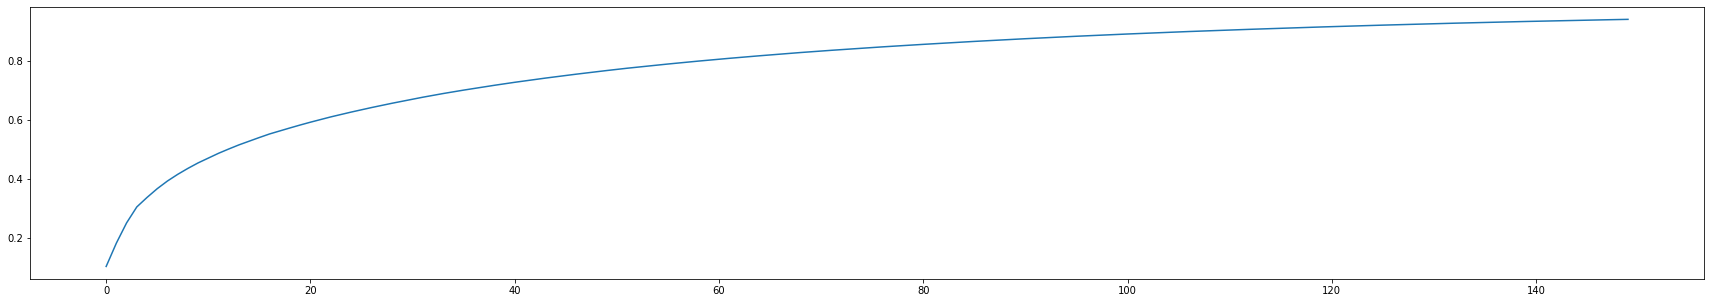

In [29]:
user_emb_pca_df = generate_pca_df(150, user_emb_df)

In [30]:
user_emb_pca_df.to_pickle('../../data/user_emb_pca_df.pkl')

### Combine PCA results with user_static_df

In [31]:
user_context = user_static_df.merge(user_emb_pca_df, left_index=True, right_index=True).progress_apply(lambda x: x)

  0%|          | 0/175 [00:00<?, ?it/s]

In [32]:
user_context.rename(columns={a: f'u{a}' for a in range(150)}, inplace=True)

In [33]:
user_context.to_pickle('../../data/user_context.pkl')

---
## Item PCA DF

In [33]:
ITEM_FEAT = pd.DataFrame(ITEM_EMB_BY_IDX).astype('float32') # decrease processing time

[0.09185424 0.1590648  0.20651275 0.24673574 0.28087178 0.30964017
 0.33420947 0.35489082 0.3738962  0.39208773 0.40833417 0.42332864
 0.4381632  0.4524407  0.4654528  0.47825888 0.49019068 0.5011532
 0.51156205 0.5218657  0.5317607  0.5415093  0.5509691  0.5598123
 0.56840783 0.57682097 0.58500284 0.5928495  0.6003294  0.60759246
 0.61456263 0.6214828  0.6281906  0.63478285 0.64132583 0.6475264
 0.6536073  0.6595825  0.6654619  0.671157   0.6766955  0.68202263
 0.68728983 0.69238836 0.6973817  0.7022716  0.7069993  0.7116251
 0.7161606  0.72060394 0.72500646 0.7292951  0.73351145 0.73764306
 0.74164814 0.7455873  0.7494272  0.75315356 0.75678205 0.7603624
 0.7639057  0.76727426 0.77060586 0.7738977  0.7771441  0.7802979
 0.7834131  0.7864553  0.78946286 0.7924161  0.7953071  0.7981222
 0.8009145  0.8036519  0.8063223  0.8089756  0.8115894  0.81415707
 0.8167151  0.8192359  0.821678   0.82409537 0.82649505 0.82883126
 0.8311446  0.83338344 0.8355699  0.8377065  0.8397968  0.8418606
 0.

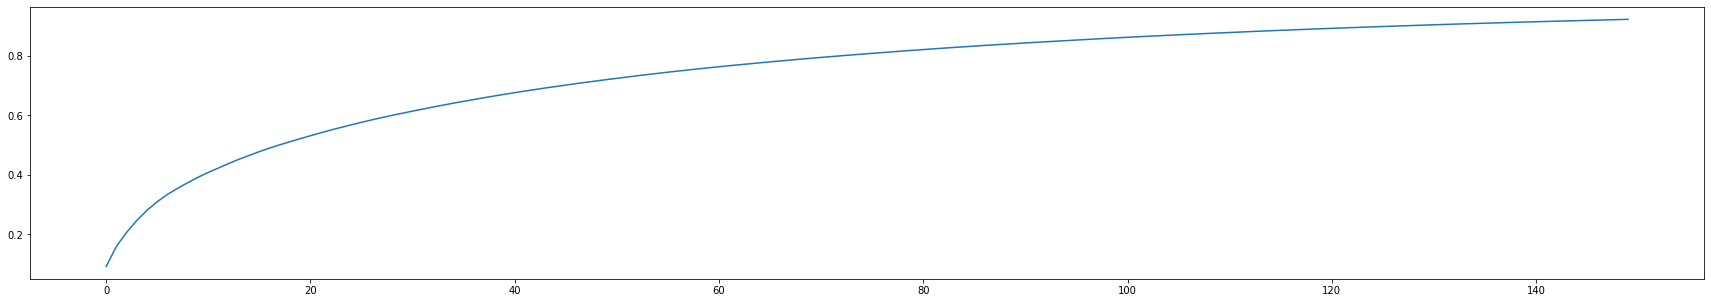

In [38]:
item_pca_df = generate_pca_df(150, ITEM_FEAT)

In [40]:
item_pca_df.rename(columns={a: f'i{a}' for a in range(150)}, inplace=True)

In [41]:
item_pca_df.to_pickle('../../data/item_pca_df.pkl')

---
## Training Order Table

In [51]:
streamer_stream_list = DATA.loc[:, ['streamer_id', 'stream']].groupby(['streamer_id', 'stream']).count().index.tolist()

In [53]:
streamer_stream_dict = {}
for (streamer, stream) in streamer_stream_list:
  try:
    streamer_stream_dict[streamer].append(stream)
  except:
    streamer_stream_dict[streamer] = [stream]

In [57]:
with open('../../data/streamer_stream_dict.pkl', 'wb') as handle:
  pickle.dump(streamer_stream_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
with open('../../data/stream_list.pkl', 'wb') as handle:
  pickle.dump(DATA.stream.unique(), handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## Item List for each stream

In [21]:
stream_item = DATA.groupby(['stream'])['uniq_item_idx'].apply(list)

KeyError: 'stream'

In [12]:
STREAM_ITEM_DICT = {}

for stream in tqdm(stream_item.index):
  # Find each stream's items
  # Put result into dict
  STREAM_ITEM_DICT[stream] = list(set(stream_item[stream]))

NameError: name 'stream_item' is not defined

In [81]:
with open('stream_item_dict.pkl', 'wb') as handle:
  pickle.dump(STREAM_ITEM_DICT, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## Bought List

In [89]:
item_gb_asid = DATA[['consumer_id', 'uniq_item_idx']].groupby('consumer_id')['uniq_item_idx']
bought_dict = {k: list(set(v)) for k, v in tqdm(item_gb_asid)}

  0%|          | 0/176783 [00:00<?, ?it/s]

In [90]:
with open('user_bought_dict.pkl', 'wb') as handle:
  pickle.dump(bought_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## Available Files

||Title|File Name|
|---|-----|---------|
|order|Stream group by streamers|`streamer_stream_dict.pkl`|
||Stream list|`stream_list.pkl`|
|Context|Final user context|`user_context.pkl`|
||Streamer context|`streamer.pkl`|
||Item context|`item_pca_df.pkl`|
|Aux|stream: items list|`stream_item_dict.pkl`|
||item list the consumer actually bought|`user_bought_dict`|

In [91]:
%%html
<style>
table {float:left}
</style>

---
## Merge Dataset

### By Streams

In [94]:
stream_list = pd.read_pickle('../../data/stream_list.pkl')

In [95]:
stream_list

array([   0,    1,    2, ..., 9338, 9339, 9340])

In [54]:
user_context.xs(0, level='stream')

,shipment_0,shipment_1,shipment_2,shipment_3,shipment_4,shipment_5,shipment_6,payment_0,payment_1,payment_2,...,u140,u141,u142,u143,u144,u145,u146,u147,u148,u149
consumer_id,,,,,,,,,,,,,,,,,,,,,
10164637738080171,0,0,0,1,0,0,0,0,0,0,...,0.220204,-0.095383,-0.032578,-0.070913,0.117286,-0.019147,-0.214947,0.042961,0.046981,0.036654
10212590544997940,0,0,1,0,0,0,0,0,0,0,...,-0.128157,0.278015,-0.144371,0.020564,0.032589,-0.171805,0.079588,0.283418,-0.188665,0.138657
10214920900967451,0,0,0,1,0,0,0,0,0,0,...,0.091800,0.124105,0.186145,-0.055650,0.095261,-0.059587,-0.007885,0.017278,0.024918,-0.089087
10218927698801004,0,0,0,1,0,0,0,0,0,1,...,-0.110433,-0.257767,0.028850,-0.061884,0.080152,0.008619,0.050463,0.156730,0.058131,0.083050
109363754438361,0,0,0,0,0,1,0,0,0,0,...,0.220204,-0.095383,-0.032578,-0.070913,0.117286,-0.019147,-0.214947,0.042961,0.046981,0.036654
1180817975623930,0,0,0,1,0,0,0,0,0,0,...,-0.170253,0.202354,-0.142907,0.143603,0.081632,0.069361,-0.023726,-0.070086,0.169859,-0.086616
1390073757839094,0,0,0,1,0,0,0,0,0,1,...,-0.042230,-0.126055,0.141839,-0.122820,0.080525,-0.115853,0.046557,0.101804,0.167362,0.046568
1750931048395893,0,0,0,1,0,0,0,0,0,0,...,0.128871,0.232959,0.019153,-0.001037,-0.138806,-0.147004,0.495755,0.122705,0.005504,-0.105608
1856577764473206,0,0,0,2,0,0,0,0,0,0,...,0.018889,0.046368,0.030750,0.068582,0.039527,-0.096871,0.049737,0.045088,0.005761,-0.083571


---
## Get Stream: User list

In [125]:
user_context = pd.read_pickle('../../data/user_context.pkl')
# stream_list = pd.read_pickle('../../data/stream_list.pkl')

In [9]:
stream_users = {}
for stream in stream_list:
  users = list(user_context.xs(stream, level="stream").index)
  stream_users[stream] = users

In [11]:
with open('../../data/stream_users_dict.pkl', 'wb') as handle:
  pickle.dump(stream_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## stream_item_dict to list element


In [22]:
STREAM_ITEM_DICT = pd.read_pickle('../../data/stream_item_dict.pkl')

In [23]:
for k in STREAM_ITEM_DICT.keys():
  STREAM_ITEM_DICT[k] = list(STREAM_ITEM_DICT[k])

In [25]:
with open('stream_item_dict.pkl', 'wb') as handle:
  pickle.dump(STREAM_ITEM_DICT, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
## MinMax Scaler for Discrete/Count/Price

In [38]:
for b, a in zip(user_context.loc[('100000231461089', 8526)], user_context.columns): print(a, b)

shipment_0 0.0
shipment_1 0.0
shipment_2 0.0
shipment_3 1.0
shipment_4 0.0
shipment_5 0.0
shipment_6 0.0
payment_0 0.0
payment_1 0.0
payment_2 0.0
payment_3 0.0
payment_4 0.0
payment_5 1.0
payment_6 0.0
payment_7 0.0
payment_8 0.0
channel_cnt 1.0
streamer_id 1.0
item_var_cnt 1.0
order_cnt 1.0
discount 1.0
shipment_fee 0.0
total_price 2999.0
avg_item_cnt 1.0
avg_item_price 2999.0
u0 -2.0155658183489273
u1 -0.1938660689568741
u2 -0.18309409629278023
u3 -0.5792170545137147
u4 -0.11841709789369337
u5 0.2089976485373161
u6 -0.12042377908242546
u7 0.2422096443275789
u8 -0.05309536728861403
u9 -0.6668196191591294
u10 0.44599152021338834
u11 0.01592576934883821
u12 -0.11691241733959816
u13 0.05877572628249073
u14 -0.044223595413918
u15 -0.4671524127302679
u16 0.11132727945435766
u17 0.13827124085418782
u18 0.3238607909489424
u19 0.05878652491283564
u20 -0.14109636002727155
u21 -0.6247406216696618
u22 0.6824331987390247
u23 -0.0849739539399208
u24 0.14256196987118877
u25 8.218213286572211e-05
u

In [19]:
convert_cols = user_context.loc[:, 'shipment_0':'avg_item_price']

In [20]:
from sklearn.preprocessing import MinMaxScaler

convert_cols_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(convert_cols)

In [25]:
convert_cols_scaled_df = pd.DataFrame(convert_cols_scaled, index=convert_cols.index, columns=convert_cols.columns)

In [23]:
convert_cols

shipment_0  shipment_1  shipment_2  \
consumer_id                       stream                                       
100000231461089                   8526             0           0           0   
1000057940522534                  3731             0           0           0   
                                  3742             0           0           0   
                                  4215             0           0           0   
                                  4267             0           0           0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461              0           0           0   
                                  842              0           0           0   
                                  1006             0           0           0   
Uffbbcd4c509268b8b16147e5e128722e 5623             0           0           0   
                                  5709             0           0           0   

                                          shipment_3  shipment_4  shipment_5  \
consumer_id                       stream                                       
100000231461089                   8526             1           0           0   
1000057940522534                  3731             5           0           0   
                                  3742             3           0           0   
                                  4215             2           0           0   
                                  4267             5           0           0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461              2           0           0   
                                  842              3           0           0   
                                  1006             4           0           0   
Uffbbcd4c509268b8b16147e5e128722e 5623             1           0           0   
                                  5709             2           0           0   

                                          shipment_6  payment_0  payment_1  \
consumer_id                       stream                                     
100000231461089                   8526             0          0          0   
1000057940522534                  3731             0          0          0   
                                  3742             0          0          0   
                                  4215             0          0          0   
                                  4267             0          0          0   
...                                              ...        ...        ...   
Uffb50137571903b41efcbb49829729a7 461              0          0          0   
                                  842              0          0          0   
                                  1006             0          0          0   
Uffbbcd4c509268b8b16147e5e128722e 5623             0          0          0   
                                  5709             0          0          0   

                                          payment_2  ...  payment_8  \
consumer_id                       stream             ...              
100000231461089                   8526            0  ...          0   
1000057940522534                  3731            0  ...          0   
                                  3742            0  ...          0   
                                  4215            0  ...          0   
                                  4267            0  ...          0   
...                                             ...  ...        ...   
Uffb50137571903b41efcbb49829729a7 461             0  ...          0   
                                  842             0  ...          0   
                                  1006            0  ...          0   
Uffbbcd4c509268b8b16147e5e128722e 5623            0  ...          0   
                                  5709            0  ...          0   

                     

In [27]:
user_context.loc[:, 'shipment_0':'avg_item_price'] = convert_cols_scaled_df

In [28]:
user_context.loc[:, 'shipment_0':'avg_item_price']


shipment_0  shipment_1  shipment_2  \
consumer_id                       stream                                       
100000231461089                   8526           0.0         0.0         0.0   
1000057940522534                  3731           0.0         0.0         0.0   
                                  3742           0.0         0.0         0.0   
                                  4215           0.0         0.0         0.0   
                                  4267           0.0         0.0         0.0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461            0.0         0.0         0.0   
                                  842            0.0         0.0         0.0   
                                  1006           0.0         0.0         0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623           0.0         0.0         0.0   
                                  5709           0.0         0.0         0.0   

                                          shipment_3  shipment_4  shipment_5  \
consumer_id                       stream                                       
100000231461089                   8526      0.010309         0.0         0.0   
1000057940522534                  3731      0.051546         0.0         0.0   
                                  3742      0.030928         0.0         0.0   
                                  4215      0.020619         0.0         0.0   
                                  4267      0.051546         0.0         0.0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461       0.020619         0.0         0.0   
                                  842       0.030928         0.0         0.0   
                                  1006      0.041237         0.0         0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623      0.010309         0.0         0.0   
                                  5709      0.020619         0.0         0.0   

                                          shipment_6  payment_0  payment_1  \
consumer_id                       stream                                     
100000231461089                   8526           0.0        0.0        0.0   
1000057940522534                  3731           0.0        0.0        0.0   
                                  3742           0.0        0.0        0.0   
                                  4215           0.0        0.0        0.0   
                                  4267           0.0        0.0        0.0   
...                                              ...        ...        ...   
Uffb50137571903b41efcbb49829729a7 461            0.0        0.0        0.0   
                                  842            0.0        0.0        0.0   
                                  1006           0.0        0.0        0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623           0.0        0.0        0.0   
                                  5709           0.0        0.0        0.0   

                                          payment_2  ...  payment_8  \
consumer_id                       stream             ...              
100000231461089                   8526          0.0  ...        0.0   
1000057940522534                  3731          0.0  ...        0.0   
                                  3742          0.0  ...        0.0   
                                  4215          0.0  ...        0.0   
                                  4267          0.0  ...        0.0   
...                                             ...  ...        ...   
Uffb50137571903b41efcbb49829729a7 461           0.0  ...        0.0   
                                  842           0.0  ...        0.0   
                                  1006          0.0  ...        0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623          0.0  ...        0.0   
                                  5709          0.0  ...        0.0   

                     

In [29]:
user_context.to_pickle('../../data/user_context.pkl')

---
## Diff Vector for User Context

In [103]:
user_context.index

MultiIndex([(                  '100000231461089', 8526),
            (                 '1000057940522534', 3731),
            (                 '1000057940522534', 3742),
            (                 '1000057940522534', 4215),
            (                 '1000057940522534', 4267),
            (                 '1000057940522534', 4852),
            (                 '1000057940522534', 4993),
            (                 '1000057940522534', 5107),
            (                 '1000057940522534', 5712),
            (                 '1000060790463557', 1930),
            ...
            ('Uff6ec0ef27457a0609e3ea4b63fe720b',  372),
            ('Uff8e22ff2e8b21298ccac9fded3ce22f', 5119),
            ('Uffa963ea05481cb0fad23ead3ba3df77', 3275),
            ('Uffaf197778f4cddff2791cf34d293d52', 8690),
            ('Uffb50137571903b41efcbb49829729a7',  452),
            ('Uffb50137571903b41efcbb49829729a7',  461),
            ('Uffb50137571903b41efcbb49829729a7',  842),
            ('U

In [104]:
user_list = DATA.consumer_id.unique()

In [12]:
diff_vectors = pd.DataFrame(columns=user_context.columns, index=user_context.index)

In [25]:
'1000057940522534' in user_context.index

True

In [26]:
for user in tqdm(user_list):
  if user not in user_context.index: continue
  current_ucontext = user_context.xs(user, level='consumer_id')
  # for stream in current_ucontext.index:
  i = 1
  while i < len(current_ucontext.index):
    curr = current_ucontext.iloc[i]
    prev = current_ucontext.iloc[i - 1]
    diff_vectors.loc[(user, current_ucontext.index[i])] = curr - prev
    i+=1

  0%|          | 0/176926 [00:00<?, ?it/s]

In [28]:
diff_vectors = diff_vectors.dropna()

In [29]:
diff_vectors.shape

(1444095, 175)

In [30]:
diff_vectors.to_pickle('../../data/raw_diff_vectors.pkl')

In [53]:
diff_vectors.shape

(1444095, 175)

[0.09605985 0.15364563 0.20406235 0.24391509 0.27821318 0.30673649
 0.33067402 0.35426443 0.37710931 0.39678006 0.41480133 0.43263728
 0.44899277 0.46475768 0.48014037 0.49461306 0.50804028 0.52082748
 0.53293076 0.54477441 0.55637609 0.56735789 0.57823504 0.58858771
 0.59864299 0.6082616  0.61763584 0.6263807  0.635065   0.64360045
 0.65184826 0.65986876 0.66782497 0.67558603 0.682908   0.68992597
 0.69688877 0.70345107 0.70995639 0.71634059 0.72260003 0.72855167
 0.73444968 0.74025112 0.74594641 0.75142258 0.75674936 0.76201673
 0.76713117 0.77223213 0.77709824 0.78193805 0.78667602 0.79129431
 0.79579275 0.80016795 0.80449877 0.80881872 0.81301477 0.81706831
 0.82097757 0.82478354 0.82854978 0.83226774 0.83593834 0.83955543
 0.84308401 0.84655115 0.84992044 0.8531535  0.85635493 0.85948945
 0.8626127  0.86565095 0.86865426 0.87162158 0.87449066 0.87730175
 0.88003414 0.88274376 0.88542594 0.88806143 0.89066287 0.89321707
 0.89575777 0.89822101 0.90062429 0.90302636 0.90535351 0.9076

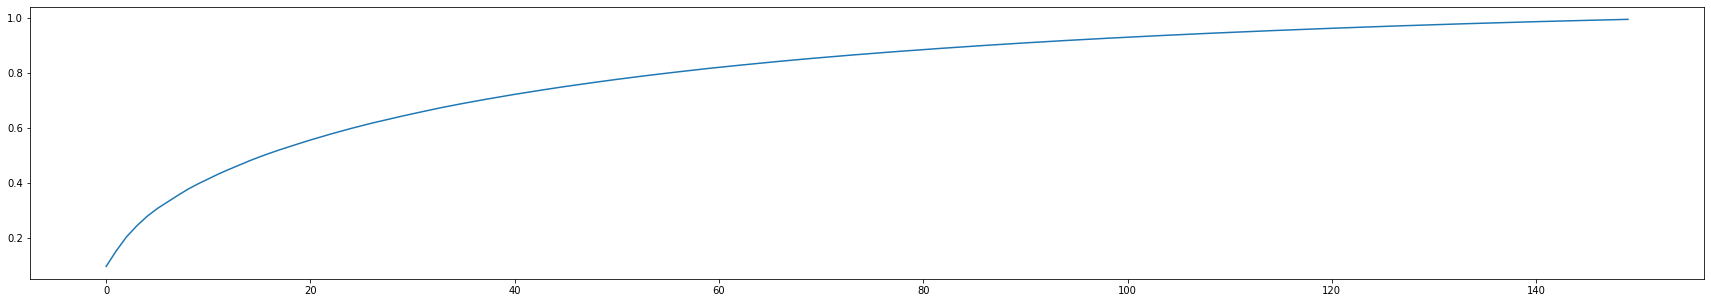

In [55]:
pca_diff_vectors = generate_pca_df(150, diff_vectors)

In [56]:
pca_diff_vectors.to_pickle('../../data/diff_vectors.pkl')

In [57]:
pca_diff_vectors

0         1         2    \
consumer_id                       stream                                 
1000057940522534                  3742   -0.121954  0.307594 -0.170226   
                                  4215   -0.618491 -0.025350 -0.782663   
                                  4267    0.882036  0.068581  0.209995   
                                  4852    0.062006  0.049634 -0.257920   
                                  4993   -0.323417 -0.113993  0.416840   
...                                            ...       ...       ...   
Uff4d074f674ad9495764995e51d905ee 2681   -0.363744  0.061613 -0.176587   
Uffb50137571903b41efcbb49829729a7 461     0.403241 -1.336488  0.898459   
                                  842     0.095158 -0.804719  0.282470   
                                  1006   -0.718317  0.430597 -0.067351   
Uffbbcd4c509268b8b16147e5e128722e 5709    0.214331 -0.392767 -0.034421   

                                               3         4         5    \
consumer_id                       stream                                 
1000057940522534                  3742   -0.079662 -0.257445 -0.204898   
                                  4215   -0.067867 -0.007476  0.087869   
                                  4267    0.139997 -0.088187  0.027628   
                                  4852   -0.370842 -0.083978  0.046244   
                                  4993   -0.197795 -0.008785 -0.321973   
...                                            ...       ...       ...   
Uff4d074f674ad9495764995e51d905ee 2681   -0.382545 -0.060765  0.146768   
Uffb50137571903b41efcbb49829729a7 461    -0.253656 -0.123856 -0.576888   
                                  842     0.277858  0.292067  0.058752   
                                  1006    0.141848 -0.321883  0.192314   
Uffbbcd4c509268b8b16147e5e128722e 5709    0.684887  0.279658  0.218292   

                                               6         7         8    \
consumer_id                       stream                                 
1000057940522534                  3742    0.129491  0.109994 -0.190158   
                                  4215   -0.043564 -0.524130 -0.004335   
                                  4267    0.055301  0.179387  0.153546   
                                  4852   -0.176585  0.034500 -0.128539   
                                  4993   -0.039204  0.156778 -0.390209   
...                                            ...       ...       ...   
Uff4d074f674ad9495764995e51d905ee 2681    0.581228  0.296927  0.116483   
Uffb50137571903b41efcbb49829729a7 461     0.494526 -0.425380 -0.343045   
                                  842     0.091570 -0.068168  0.168166   
                                  1006    0.201056 -0.189126  0.048613   
Uffbbcd4c509268b8b16147e5e128722e 5709    0.502372  0.314740  0.026365   

                                               9    ...       140       141  \
consumer_id                       stream            ...                       
1000057940522534                  3742   -0.374083  ... -0.013534  0.030704   
                                  4215    0.065837  ... -0.069054 -0.055219   
                                  4267    0.248857  ... -0.032596  0.002234   
                                  4852    0.052615  ... -0.024895  0.041435   
                                  4993    0.026069  ...  0.048461 -0.042500   
...                                            ...  ...       ...       ...   
Uff4d074f674ad9495764995e51d905ee 2681    0.458407  ...  0.006702  0.023190   
Uffb50137571903b41efcbb49829729a7 461    -0.687907  ... -0.030156 -0.059315   
                                  842    -0.180631  ... -0.031154 -0.062216   
                                  1006   -0.056922  ... -0.015099  0.005846   
Uffbbcd4c509268b8b16147e5e128722e 5709    0.027032  ...  0.003771 -0.147375   

                                               142       143       144  \
consumer_id                       stream                

In [58]:
user_context

shipment_0  shipment_1  shipment_2  \
consumer_id                       stream                                       
100000231461089                   8526           0.0         0.0         0.0   
1000057940522534                  3731           0.0         0.0         0.0   
                                  3742           0.0         0.0         0.0   
                                  4215           0.0         0.0         0.0   
                                  4267           0.0         0.0         0.0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461            0.0         0.0         0.0   
                                  842            0.0         0.0         0.0   
                                  1006           0.0         0.0         0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623           0.0         0.0         0.0   
                                  5709           0.0         0.0         0.0   

                                          shipment_3  shipment_4  shipment_5  \
consumer_id                       stream                                       
100000231461089                   8526      0.010309         0.0         0.0   
1000057940522534                  3731      0.051546         0.0         0.0   
                                  3742      0.030928         0.0         0.0   
                                  4215      0.020619         0.0         0.0   
                                  4267      0.051546         0.0         0.0   
...                                              ...         ...         ...   
Uffb50137571903b41efcbb49829729a7 461       0.020619         0.0         0.0   
                                  842       0.030928         0.0         0.0   
                                  1006      0.041237         0.0         0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623      0.010309         0.0         0.0   
                                  5709      0.020619         0.0         0.0   

                                          shipment_6  payment_0  payment_1  \
consumer_id                       stream                                     
100000231461089                   8526           0.0        0.0        0.0   
1000057940522534                  3731           0.0        0.0        0.0   
                                  3742           0.0        0.0        0.0   
                                  4215           0.0        0.0        0.0   
                                  4267           0.0        0.0        0.0   
...                                              ...        ...        ...   
Uffb50137571903b41efcbb49829729a7 461            0.0        0.0        0.0   
                                  842            0.0        0.0        0.0   
                                  1006           0.0        0.0        0.0   
Uffbbcd4c509268b8b16147e5e128722e 5623           0.0        0.0        0.0   
                                  5709           0.0        0.0        0.0   

                                          payment_2  ...      u140      u141  \
consumer_id                       stream             ...                       
100000231461089                   8526          0.0  ...  0.043345  0.182636   
1000057940522534                  3731          0.0  ... -0.005612 -0.018415   
                                  3742          0.0  ...  0.027203 -0.046292   
                                  4215          0.0  ...  0.039489 -0.051979   
                                  4267          0.0  ...  0.063265 -0.042580   
...                                             ...  ...       ...       ...   
Uffb50137571903b41efcbb49829729a7 461           0.0  ...  0.026422  0.056281   
                                  842           0.0  ...  0.056678  0.030333   
                                  1006          0.0  ...  0.053411 -0.012786   
Uffbbcd4c509268b8b16147e5e128722e 5623          0.0  ... -0.16870

---
## Diff Vectors

In [2]:
raw_diff_vectors = pd.read_pickle('../../data/raw_diff_vectors.pkl')

### SVD

In [15]:
from sklearn.decomposition import TruncatedSVD

# 創建 TruncatedSVD 實例
svd = TruncatedSVD(n_components=150)

# 將原始矩陣 A 轉換為 n x k 的矩陣 B
svd_diff_vectors = svd.fit_transform(raw_diff_vectors)

print("轉換後的矩陣 B：\n", svd_diff_vectors)

KeyboardInterrupt: 

In [35]:
svd_diff_vectors = pd.DataFrame(svd_diff_vectors, index=raw_diff_vectors.index)

In [36]:
svd_diff_vectors.shape

(1444095, 150)

In [37]:
svd_diff_vectors.to_pickle('../../data/svd_diff_vector.pkl')

---
### VAE dimension reduction

In [4]:
raw_diff_vectors = raw_diff_vectors.astype('float32')

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 設定超參數
input_dim = 175
hidden_dim = 64
latent_dim = 10
output_dim = 175
learning_rate = 1e-4
num_epochs = 30

# 轉換為 PyTorch 張量並創建數據加載器
X_tensor = torch.from_numpy(raw_diff_vectors.values).float()
data_loader = DataLoader(TensorDataset(X_tensor), batch_size=256, shuffle=True)

# 定義 VAE 模型
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def forward(self, x):
        z_mu_logvar = self.encoder(x)
        mu, log_var = torch.chunk(z_mu_logvar, 2, dim=-1)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

# 初始化模型和優化器
model = VAE(input_dim, hidden_dim, latent_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
mse_loss = nn.MSELoss()

# 訓練模型
for epoch in range(num_epochs):
    for batch_idx, data in enumerate(data_loader):
        x = data[0]
        x_hat, mu, log_var = model(x)
        reconstruction_loss = mse_loss(x_hat, x)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = reconstruction_loss + kl_divergence
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 使用訓練好的模型進行降維
model.eval()
with torch.no_grad():
    X_encoded = model.encoder(X_tensor).numpy()
X_encoded_df = pd.DataFrame(X_encoded)

Epoch [1/30], Loss: 0.0156
Epoch [2/30], Loss: 0.0159
Epoch [3/30], Loss: 0.0156
Epoch [4/30], Loss: 0.0159
Epoch [5/30], Loss: 0.0169
Epoch [6/30], Loss: 0.0143
Epoch [7/30], Loss: 0.0157
Epoch [8/30], Loss: 0.0151
Epoch [9/30], Loss: 0.0155
Epoch [10/30], Loss: 0.0159
Epoch [11/30], Loss: 0.0157
Epoch [12/30], Loss: 0.0142
Epoch [13/30], Loss: 0.0150
Epoch [14/30], Loss: 0.0141
Epoch [15/30], Loss: 0.0157
Epoch [16/30], Loss: 0.0156
Epoch [17/30], Loss: 0.0154
Epoch [18/30], Loss: 0.0152
Epoch [19/30], Loss: 0.0148
Epoch [20/30], Loss: 0.0154
Epoch [21/30], Loss: 0.0157
Epoch [22/30], Loss: 0.0158
Epoch [23/30], Loss: 0.0163
Epoch [24/30], Loss: 0.0156
Epoch [25/30], Loss: 0.0151
Epoch [26/30], Loss: 0.0162
Epoch [27/30], Loss: 0.0158
Epoch [28/30], Loss: 0.0156
Epoch [29/30], Loss: 0.0162
Epoch [30/30], Loss: 0.0150


In [ ]:
X_encoded_df.shape

(1444095, 150)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_encoded_df_scaled = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_encoded_df)

In [ ]:
X_encoded_scaled_df = pd.DataFrame(X_encoded_df_scaled, index=raw_diff_vectors.index)

In [ ]:
X_encoded_scaled_df.to_pickle('../../data/diff_vectors_vae.pkl')

### VAE reconstruction error

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

mse_loss = nn.MSELoss()

x = torch.tensor(raw_diff_vectors.values).float()
x_hat, _, _ = model(x)
mes = mse_loss(x_hat, x)

In [7]:
x.shape

torch.Size([1444095, 175])

In [8]:
x_hat.shape

torch.Size([1444095, 175])

In [9]:
mse = [mse_loss(a, b) for a, b in zip(x_hat, x)]

In [10]:
mse_list = list(map(lambda x: x.item(), mse))

In [11]:
mse_df = pd.DataFrame(mse_list, index=raw_diff_vectors.index)

In [12]:
mse_df.to_pickle('../../data/vae_recons_64_df.pkl')

In [30]:
mse_df.hist(bins=50)

NameError: name 'mse_df' is not defined

In [16]:
mse_df.describe()

,0
count,1.444095e+06
mean,1.552166e-02
std,9.127026e-03
min,4.769593e-08
25%,8.261949e-03
50%,1.401837e-02
75%,2.122866e-02
max,1.055335e-01


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

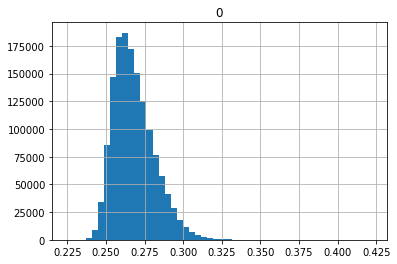

In [15]:
vae_recons = pd.read_pickle('../../data/vae_recons_df.pkl')
vae_recons.hist(bins=50)

---
## PLS
### Prepare Data

In [17]:
DATA.columns

Index(['訂單編號', '下單日期', '時間戳記', 'consumer_id', 'streamer_id', 'channel_name',
       'item_id', '單價', '數量', '折扣', '總金額', '付款單號', '專屬折扣', '運費', '收款金額',
       '付款方式', '運送方式', 'stream', 'date', '處理後名稱', 'class', 'uniq_item_idx',
       'city', 'area'],
      dtype='object')

In [18]:
'''
Calculate user cumulated stream embedding
* user_stream_order_dict: { User: [stream list in order] }
* buy list: [consumer_id, streams]
* 需求：可以選擇要「給予權重」或「直接平均」
'''
user_stream_order = DATA[['consumer_id', 'stream']].groupby(['consumer_id'])['stream'].apply(set)
USER_LIST = DATA['consumer_id'].unique().tolist()
# test consumer_id: ['1000057940522534']
# test streams: {3627, 3638, 4091, 4141, 4707, 4841, 4942, 5508}

In [19]:
user_stream_order['1000057940522534']

{3731, 3742, 4215, 4267, 4852, 4993, 5107, 5712}

In [20]:
user_stream_buy_list = DATA.groupby(['consumer_id', 'stream'])['uniq_item_idx'].apply(list)

In [21]:
# WEIGHTED
AVG_EMB = {}
for consumer_id in tqdm(USER_LIST):
  # find all the stream user attended and sort them in time order
  streamlist = list(user_stream_order[consumer_id])
  streamlist.sort()
  # find items bought in each stream
  buylist = [user_stream_buy_list[consumer_id, stream] for stream in streamlist]
  
  # convert buylist to bert embeddings
  single_stream_emb = []
  for items in buylist:
    # all_buy_item_index = [BERT_INDEX[item] for item in items]
    single_stream_emb.append(ITEM_EMB_BY_IDX[items].mean(axis=0))
  
  # weighted avg
  for (i, s), emb in zip(enumerate(streamlist), single_stream_emb):
    # f_emb = emb if i == 0 else (AVG_EMB[(consumer_id, streamlist[i-1])] + emb)/2
    AVG_EMB[(consumer_id, s)] = emb

  0%|          | 0/176783 [00:00<?, ?it/s]

In [22]:
with open('../../data/avg_emb_for_pls.pkl', 'wb') as handle:
    pickle.dump(AVG_EMB, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
%%time
embseries_dict = {}
for key, item in tqdm(AVG_EMB.items()):
  embseries_dict[key] = pd.Series(item)
len(embseries_dict) == len(AVG_EMB)

  0%|          | 0/1620878 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 989 ms, total: 1min 32s
Wall time: 1min 32s


True

In [26]:
with open('../../data/pls_embseries_dict.pkl', 'wb') as handle:
    pickle.dump(embseries_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### PLS 開始降維

In [2]:
embseries_dict = pd.read_pickle('../../data/pls_embseries_dict.pkl')

In [2]:
raw_diff_vectors = pd.read_pickle('../../data/raw_diff_vectors.pkl')

In [4]:
def apply_emb(row):
  return embseries_dict[row.name]

In [5]:
pls_y_df = raw_diff_vectors.progress_apply(lambda x: apply_emb(x), axis=1)

  0%|          | 0/1444095 [00:00<?, ?it/s]

In [6]:
with open('../../data/pls_y_df.npy', 'wb') as f:
    np.save(f, pls_y_df.values)

In [3]:
type(raw_diff_vectors.values)

numpy.ndarray

In [4]:
from sys import getsizeof

In [5]:
getsizeof(raw_diff_vectors)

8114193843

In [6]:
getsizeof(raw_diff_vectors.values)

112

In [3]:
pls_y = np.load('../../data/pls_y_df.npy')

In [ ]:
from sklearn.cross_decomposition import PLSRegression

# 初始化PLS模型
upls = PLSRegression(n_components=150)

# 訓練PLS模型/計算潛在變量
T = upls.fit_transform(X=raw_diff_vectors.values, y=pls_y)

In [1]:
X = [[0., 0., 1.], [1.,0.,0.], [2.,2.,2.], [2.,5.,4.]]
Y = [[0.1, -0.2], [0.9, 1.1], [6.2, 5.9], [11.9, 12.3]]
pls2 = PLSRegression(n_components=2)
pls2.fit_transform(X, Y)

NameError: name 'PLSRegression' is not defined

## VAE Multiplier

In [25]:
# diff vectors
pca_diff = pd.read_pickle('../../data/diff_vectors_pca.pkl')
svd_diff = pd.read_pickle('../../data/diff_vectors_svd.pkl')
vae_diff = pd.read_pickle('../../data/diff_vectors_vae.pkl')

In [26]:
# VAE reconstruction errors
vae_recon = pd.read_pickle('../../data/vae_recons_df.pkl')
vae64_recon = pd.read_pickle('../../data/vae_recons_64_df.pkl')

In [27]:
mul150_pca_diff = pca_diff.multiply(vae_recon[0], axis="index")
mul150_svd_diff = svd_diff.multiply(vae_recon[0], axis="index")
mul150_vae_diff = vae_diff.multiply(vae_recon[0], axis="index")

In [28]:
mul64_pca_diff = pca_diff.multiply(vae64_recon[0], axis="index")
mul64_svd_diff = svd_diff.multiply(vae64_recon[0], axis="index")
mul64_vae_diff = vae_diff.multiply(vae64_recon[0], axis="index")

In [29]:
mul150_pca_diff.to_pickle('../../data/mul150_pca_diff.pkl')
mul150_vae_diff.to_pickle('../../data/mul150_vae_diff.pkl')
mul64_pca_diff.to_pickle('../../data/mul64_pca_diff.pkl')
mul64_vae_diff.to_pickle('../../data/mul64_vae_diff.pkl')

---
## UPD to capture dynamics

In [48]:
DATA.columns

Index(['訂單編號', '下單日期', '時間戳記', 'consumer_id', 'streamer_id', 'channel_name',
       'item_id', '單價', '數量', '折扣', '總金額', '付款單號', '專屬折扣', '運費', '收款金額',
       '付款方式', '運送方式', 'stream', 'date', '處理後名稱', 'class', 'uniq_item_idx'],
      dtype='object')

In [49]:
'''
Calculate user cumulated stream embedding
* user_stream_order_dict: { User: [stream list in order] }
* buy list: [consumer_id, streams]
* 需求：可以選擇要「給予權重」或「直接平均」
'''
user_stream_order = DATA[['consumer_id', 'stream']].groupby(['consumer_id'])['stream'].apply(set)
USER_LIST = DATA['consumer_id'].unique().tolist()
# test consumer_id: ['1000057940522534']
# test streams: {3627, 3638, 4091, 4141, 4707, 4841, 4942, 5508}

In [50]:
user_stream_order['1000057940522534']
# {3731, 3742, 4215, 4267, 4852, 4993, 5107, 5712}

{3731, 3742, 4215, 4267, 4852, 4993, 5107, 5712}

In [51]:
user_stream_buy_list = DATA.groupby(['consumer_id', 'stream'])['uniq_item_idx'].apply(list)

In [115]:
# WEIGHTED
UPD_DICT = {}
for consumer_id in tqdm(USER_LIST):
  # find all the stream user attended and sort them in time order
  streamlist = list(user_stream_order[consumer_id])
  streamlist.sort()
  cumul_buyset = set()
  for items, stream in zip(stream_buyset, streamlist):
    # items: 現在直播購買的產品 set
    # cumul_buyset: 這次直播以前的產品 set
    print(len(items & cumul_buyset), len(items | cumul_buyset))
    upd = 1-len(items & cumul_buyset)/len(items | cumul_buyset)
    UPD_DICT[(consumer_id, stream)] = upd
    cumul_buyset.update(items)
  break

  0%|          | 0/176926 [00:00<?, ?it/s]

0 3
1 5
0 8
2 9


In [119]:
pd.Series(UPD_DICT.values()).unique()

array([1.        , 0.8       , 0.77777778])

---
## User Streamer Interactions

In [120]:
DATA.columns

Index(['訂單編號', '下單日期', '時間戳記', 'consumer_id', 'streamer_id', 'channel_name',
       'item_id', '單價', '數量', '折扣', '總金額', '付款單號', '專屬折扣', '運費', '收款金額',
       '付款方式', '運送方式', 'stream', 'date', '處理後名稱', 'class', 'uniq_item_idx'],
      dtype='object')

In [121]:
DATA.groupby(['consumer_id', 'streamer_id']).count()

,,訂單編號,下單日期,時間戳記,channel_name,item_id,單價,數量,折扣,總金額,付款單號,專屬折扣,運費,收款金額,付款方式,運送方式,stream,date,處理後名稱,class,uniq_item_idx
consumer_id,streamer_id,,,,,,,,,,,,,,,,,,,,
100000231461089,12235,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1000057940522534,10891,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24,24
1000060790463557,10891,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1000082590775367,12235,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1000125800421136,27343,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uff8e22ff2e8b21298ccac9fded3ce22f,10891,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Uffa963ea05481cb0fad23ead3ba3df77,10891,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Uffaf197778f4cddff2791cf34d293d52,6897,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4


In [122]:
DATA.groupby(['consumer_id', 'streamer_id']).count().describe()

,訂單編號,下單日期,時間戳記,channel_name,item_id,單價,數量,折扣,總金額,付款單號,專屬折扣,運費,收款金額,付款方式,運送方式,stream,date,處理後名稱,class,uniq_item_idx
count,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000,196099.000000
mean,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798,27.984798
std,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236,75.583236
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
75%,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
max,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000


In [123]:
DATA.describe()

,streamer_id,item_id,單價,數量,折扣,總金額,專屬折扣,運費,收款金額,stream,uniq_item_idx
count,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06,5.487791e+06
mean,8.197363e+03,4.756658e+06,3.842292e+02,2.100025e+00,5.064428e-01,4.873819e+02,3.662681e-01,8.125868e+01,3.098562e+03,5.163044e+03,1.434792e+04
std,3.337305e+03,1.310088e+06,7.141988e+02,4.604594e+00,1.106449e+01,8.282531e+02,1.317420e+01,5.039119e+01,3.704993e+03,2.252215e+03,9.954595e+03
min,4.123000e+03,5.797650e+05,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-1.500000e+03,0.000000e+00,0.000000e+00
25%,6.835000e+03,3.602116e+06,5.000000e+01,1.000000e+00,0.000000e+00,8.800000e+01,0.000000e+00,6.000000e+01,1.100000e+03,3.477000e+03,4.480000e+03
50%,6.897000e+03,4.691059e+06,1.390000e+02,1.000000e+00,0.000000e+00,2.000000e+02,0.000000e+00,8.000000e+01,1.982000e+03,5.236000e+03,1.460000e+04
75%,1.089100e+04,5.883059e+06,3.990000e+02,2.000000e+00,0.000000e+00,5.880000e+02,0.000000e+00,1.000000e+02,3.680000e+03,6.982000e+03,2.154700e+04
max,2.734300e+04,7.300619e+06,1.750000e+05,1.800000e+03,8.040000e+03,2.384450e+05,1.569000e+03,9.000000e+02,2.384450e+05,9.340000e+03,3.701400e+04


---
## Diff Vector with only Item Features

In [2]:
user_context = pd.read_pickle('../../data/user_context.pkl')
user_context.columns

Index(['shipment_0', 'shipment_1', 'shipment_2', 'shipment_3', 'shipment_4',
       'shipment_5', 'shipment_6', 'payment_0', 'payment_1', 'payment_2',
       ...
       'u140', 'u141', 'u142', 'u143', 'u144', 'u145', 'u146', 'u147', 'u148',
       'u149'],
      dtype='object', length=175)

In [3]:
cols = [f'u{i}' for i in range(150)]
item_part_ucontext = user_context.loc[:, cols]

In [4]:
item_part_ucontext.shape

(1620878, 150)

In [3]:
user_list = user_context.index.get_level_values(0).unique()

In [12]:
diff_vectors = pd.DataFrame(columns=item_part_ucontext.columns, index=item_part_ucontext.index)

In [13]:
for user in tqdm(user_list):
  if user not in item_part_ucontext.index: continue
  current_ucontext = item_part_ucontext.xs(user, level='consumer_id')
  # for stream in current_ucontext.index:
  i = 1
  while i < len(current_ucontext.index):
    curr = current_ucontext.iloc[i]
    prev = current_ucontext.iloc[i - 1]
    diff_vectors.loc[(user, current_ucontext.index[i])] = curr - prev
    i+=1

  0%|          | 0/176783 [00:00<?, ?it/s]

In [14]:
diff_vectors = diff_vectors.dropna()

In [15]:
diff_vectors.shape

(1444095, 150)

---
## Synthesize

In [61]:
user_bought = DATA[['consumer_id', '處理後名稱']].groupby(['consumer_id'])['處理後名稱'].apply(list)

In [97]:
DATA['consumer_id'].unique()[2000]

'1258157967712334'

In [98]:
user_bought['1258157967712334']

['30秒順發光髮膜',
 '凱樂沙龍專業洗髮精 薄荷 凱樂沙龍專業洗髮精 玫瑰',
 "cab's二代女神膠原密帖",
 '小琳家族淘米水米精華餐具淨',
 '花王 kao attack zero濃縮洗衣精 污垢爆炸粉',
 '56吋雨傘',
 '老闆亂丟沐浴10件組',
 '成人旅行牙刷 超收',
 '讓你洗全家套組 25件組',
 'nike雙勾翻領羔羊毛外套 黑',
 '日本united athle 基本色短t',
 '日本united athle 基本色短t']

In [73]:
user_stream_buy_list = DATA.groupby(['consumer_id', 'stream'])['uniq_item_idx'].apply(list)

In [99]:
tmp = user_stream_buy_list.xs('1258157967712334', level='consumer_id').progress_apply(lambda x: list(map(lambda a: item_names[a], x)))

  0%|          | 0/8 [00:00<?, ?it/s]

In [100]:
for i, a in zip(tmp.index, tmp):
  print(i, a)
  # print(f'{a.name} {a.values}')

2363 ["cab's二代女神膠原密帖"]
2598 ['小琳家族淘米水米精華餐具淨']
2607 ['花王 kao attack zero濃縮洗衣精 污垢爆炸粉', '56吋雨傘']
3015 ['老闆亂丟沐浴10件組', '成人旅行牙刷 超收']
3055 ['讓你洗全家套組 25件組']
7245 ['nike雙勾翻領羔羊毛外套 黑']
7556 ['日本united athle 基本色短t', '日本united athle 基本色短t']
7971 ['30秒順發光髮膜', '凱樂沙龍專業洗髮精 薄荷 凱樂沙龍專業洗髮精 玫瑰']


In [94]:
actions_with_diff = [6781, 6717, 6570, 249, 6714, 6020, 6716, 6705, 6718, 6706]
[item_names[a] for a in actions_with_diff]

['帝喜牌 手打鐵鍋 有附蓋，沒鏟子',
 '車載固體淡香膏',
 'dstt 微壓悶燒鍋',
 '西華時尚木柄牛奶鍋 14cm',
 '廚房專用 清潔濕紙巾',
 'x三郎拍賣。備長碳洗衣粉一盒',
 '保溫袋 23.5cm',
 'home dry 除濕盒',
 '歌林 7吋充電兩用扇',
 '摺疊鞋架茶色 70cm']

In [96]:
with open('item_names.pkl', 'wb') as handle:
    pickle.dump(item_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

---
# Param Multiplier

In [4]:
multipliers = pd.DataFrame(columns=['multiplier'], index=user_context.index)

In [5]:
'1000057940522534' in user_context.index

True

In [6]:
for user in tqdm(user_list):
  if user not in user_context.index: continue
  current_ucontext = user_context.xs(user, level='consumer_id')
  # for stream in current_ucontext.index:
  i = 1
  while i < len(current_ucontext.index):
    curr = current_ucontext.iloc[i]
    prev = current_ucontext.iloc[i - 1]
    multipliers.loc[(user, current_ucontext.index[i]), 'multiplier'] = np.dot(curr, prev)
    i+=1

  0%|          | 0/176783 [00:00<?, ?it/s]

In [9]:
multipliers = multipliers.dropna()

In [10]:
multipliers.shape

(1444095, 1)

In [11]:
multipliers.to_pickle('../../data/dot_multiplier.pkl')

In [5]:
multipliers = pd.read_pickle('../../data/dot_multiplier.pkl')
multipliers = multipliers.astype('float32')

In [8]:
multipliers.apply(lambda x: 1/abs(x)).describe()

,multiplier
count,1.444095e+06
mean,7.364891e-01
std,8.688142e+00
min,3.342274e-02
25%,3.504231e-01
50%,5.342021e-01
75%,8.352726e-01
max,7.242473e+03


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1.5, 5)).fit(multipliers)
multipliers_scaled = scaler.transform(multipliers)

In [17]:
multipliers_df = pd.DataFrame(multipliers_scaled, index=multipliers.index, columns=multipliers.columns)

In [18]:
multipliers_df.describe()

,multiplier
count,1.444095e+06
mean,1.847033e+00
std,2.132318e-01
min,1.500000e+00
25%,1.713047e+00
50%,1.790262e+00
75%,1.902611e+00
max,5.000000e+00


In [19]:
multipliers_df.to_pickle('../../data/dot_multiplier_scaled.pkl')

In [14]:
stream_order = DATA.groupby(['stream']).count()['consumer_id']

In [16]:
stream_order.iloc[0]

75

In [17]:
stream_order.to_pickle('../../data/stream_order_cnt_list.pkl')